$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import glob
import numpy as np
import astropy.table as aTable

In [2]:
import copy
from nflows import transforms, distributions, flows

import torch
from torch import nn
from torch import optim

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
if torch.cuda.is_available(): 
    device = torch.device(type='cuda', index=0)
else: 
    device = 'cpu'

# compile $M_*$ posteriors for $z < 0.2$ galaxies

In [6]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_BRIGHT_clustering.sv3.logM.hdf5'))

In [7]:
has_posterior = (bgs['zmax'].data != -999.) & (bgs['Z'] <= 0.2)
bgs = bgs[has_posterior]

In [8]:
bgs[:5]

RA,DEC,TARGETID,NTILE,TILES,Z,COMP_TILE,rosette_number,rosette_r,FRACZ_TILELOCID,BITWEIGHTS [2],PROB_OBS,WEIGHT_ZFAIL,WEIGHT,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,NZ,WEIGHT_FKP,phi,theta,healpix,logM_mcmc [30],zmax,theta_bf [13]
float64,float64,int64,int64,bytes43,float64,float64,float64,float64,float64,int64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64,float64,float64,float64
191.20458196461243,60.31535787110577,39633390185481345,1,100,0.08969256109731599,0.64,3.0,1.613220114177946,1.0,-1 .. -1,1.0,1.0,1.0,11.618794,18.39226,20.892622,13.421043,9.27371,0.04778151135868713,0.0030821516772042766,3.3371495001818547,0.5180947424254233,11226,9.311141344469839 .. 9.30371384223851,0.244537973921384,9.299830413616577 .. 0.12427289814965596
187.83760708675698,60.38987543677365,39633393155049303,1,100,0.1731108191825362,0.64,3.0,1.7267282368438097,0.5,6932875859169517021 .. -6858338461939850770,0.4609375,1.0,2.15,13.26433,27.728409,46.020153,37.03337,25.867756,0.01270745015908088,0.01149149450827468,3.2783847027313433,0.5167941655539476,11237,10.562881907340254 .. 10.51416114213185,0.3653015609857238,10.502975152735333 .. 0.2744993206027024
186.48359894373857,61.73967570511937,39633407801558322,1,100,0.08577825488213503,0.64,3.0,1.6169466967221486,1.0,8781239440956233492 .. -7057659983223072695,0.5546875,1.0,1.7916666666666667,15.079609,20.454126,26.065075,13.486019,10.797623,0.04778151135868713,0.0030821516772042766,3.2547528025368577,0.49323570662701194,11250,9.553030097515068 .. 9.616727386110236,0.15904907192264478,9.64110366817851 .. 0.34742311547544863
189.20703625254848,60.13450219401336,39633390168704208,1,100,0.1842724056985206,0.64,3.0,1.6990866107210438,0.5,-1 .. -1,1.0,1.0,1.0,20.873507,47.31153,86.10893,73.21894,58.1018,0.01270745015908088,0.01149149450827468,3.3022857505472443,0.5212512694616096,11215,11.119193932010795 .. 11.087693511488103,0.47828502781727295,11.155540895363698 .. 0.23645233036989347
188.37549196358177,60.28363082356079,39633390160317021,1,100,0.10460016503986184,0.64,3.0,1.6863667576183226,1.0,-1 .. -1,1.0,1.0,1.0,59.504303,110.16833,163.72209,99.53286,64.68495,0.02076759884354943,0.007063011628762902,3.28777256482862,0.5186484838670199,11237,10.672187264107224 .. 10.663645655661396,0.5131675965953388,10.697130097376105 .. 0.13025520023133774


In [9]:
logM_posteriors = bgs['logM_mcmc'].data
zmaxes = bgs['zmax'].data

In [10]:
print('%i galaxies' % len(zmaxes))

70355 galaxies


(7.0, 12.5)

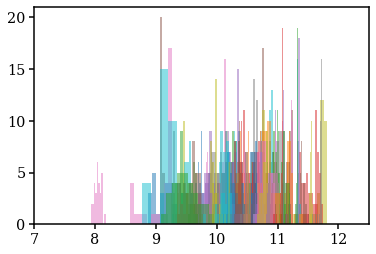

In [11]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=100, replace=False): 
    plt.hist(logM_posteriors[i,:], bins=10, alpha=0.5)
plt.xlim(7., 12.5)

# calculate $V_{\rm max}$

In [12]:
from astropy.cosmology import Planck13

In [13]:
vfull = Planck13.comoving_volume(0.2).value * Planck13.h**3 # (Mpc/h)^3
vmaxes = Planck13.comoving_volume(zmaxes.clip(0., 0.2)).value * Planck13.h**3 # (Mpc/h)^3

In [50]:
# Vmax based importance weights
w_import = vfull / vmaxes * bgs['WEIGHT'].data

as a quick check of the Vmaxes, lets take a look at the posteriors weighted by 1/Vmax

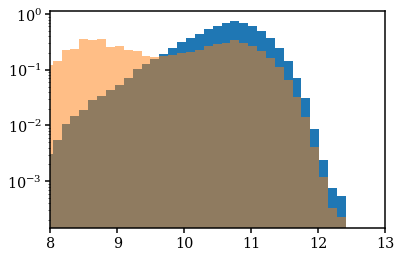

In [52]:
plt.hist(np.median(logM_posteriors, axis=1), bins=40, density=True)
plt.hist(np.median(logM_posteriors, axis=1), bins=40, weights=w_import, alpha=0.5, density=True)
plt.xlim(8., 13)
plt.yscale('log')

# estimate $p(M_* | \{x_i, z_i \})$ using NDE

In [54]:
x_data = torch.tensor(logM_posteriors.astype(np.float32)).to(device)
w_data = torch.tensor(w_import.astype(np.float32)).to(device)

In [55]:
batch_size = 128
Ntrain = int(0.9 * x_data.shape[0])
Nvalid = x_data.shape[0] - Ntrain # int(0.1 * x_data.shape[0])

trainloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_data[:Ntrain], w_data[:Ntrain]),
        batch_size=batch_size,
        shuffle=True)

validloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_data[Ntrain:Ntrain+Nvalid], w_data[Ntrain:Ntrain+Nvalid]),
        batch_size=batch_size)

In [56]:
# def Loss(flow, post, w): 
#     w_i = torch.sum(w, axis=1)
    
#     logw = torch.log(w) 
#     return -torch.sum(w_i * torch.logsumexp(logw + flow.log_prob(post.flatten()[:,None]).reshape(post.shape), axis=1))

def Loss(flow, post, w): 
    return -torch.sum(w * torch.logsumexp(flow.log_prob(post.flatten()[:,None]).reshape(post.shape), axis=1))

In [57]:
ndim = 1 

In [67]:
all_flows = []

lr = 1e-3
num_iter = 1000
patience = 20

best_valid_losses, valid_losseses = [], []
for i in range(5): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))
    print('5x%i' % nhidden)
    blocks = []
    for iblock in range(5): 
        blocks += [
            transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
            transforms.RandomPermutation(features=ndim)
        ]
    transform = transforms.CompositeTransform(blocks)

    # Define a base distribution.
    base_distribution = distributions.StandardNormal(shape=[ndim])

    # Combine into a flow.
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    # parameters = [weights, means, stdevs]
    optimizer1 = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer1, lr, total_steps=num_iter)

    best_epoch = 0 
    best_valid_loss = np.inf
    valid_losses = []
    for epoch in range(num_iter):
        train_loss = 0.
        for batch in trainloader: 
            optimizer1.zero_grad()
            loss = Loss(flow, batch[0], batch[1])
            loss.backward()
            train_loss += loss.item()
            optimizer1.step()
        train_loss /= len(trainloader.dataset)

        with torch.no_grad():
            valid_loss = 0.
            for batch in validloader: 
                loss = Loss(flow, batch[0], batch[1])
                valid_loss += loss.item()
            valid_loss /= len(validloader.dataset)           
            valid_losses.append(valid_loss)
            
            if epoch % 20 == 0: 
                print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_flow = copy.deepcopy(flow)
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
                    
        scheduler.step()
    all_flows.append(best_flow)
    valid_losseses.append(valid_losses)   
    best_valid_losses.append(best_valid_loss)

5x108
0 	 -3.29e+00 	 -3.45e+00
20 	 -4.14e+00 	 -3.61e+00
>>>24 	 -3.61278e+00
5x72
0 	 -2.70e+00 	 -3.47e+00
20 	 -4.17e+00 	 -3.50e+00
>>>27 	 -3.61829e+00
5x194
0 	 -3.48e+00 	 -3.03e+00
20 	 -4.11e+00 	 -3.44e+00
>>>28 	 -3.62571e+00
5x103
0 	 -3.38e+00 	 -3.56e+00
20 	 -4.08e+00 	 -3.60e+00
>>>32 	 -3.62473e+00
5x199
0 	 -3.74e+00 	 -3.54e+00
20 	 -4.11e+00 	 -3.61e+00
>>>30 	 -3.62589e+00


(-10.0, -0.01)

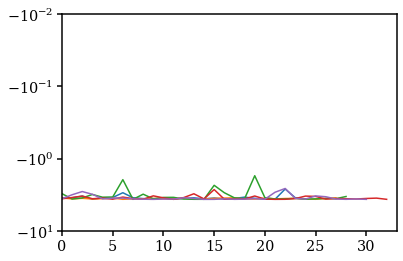

In [69]:
for vl in valid_losseses: 
    plt.plot(np.array(vl))
plt.xlim(0, np.max([len(vl) for vl in valid_losseses]))
plt.yscale('symlog', linthresh=1e-2)
plt.ylim(-1e1, -1e-2)

In [70]:
i_best = np.argmin(best_valid_losses)
#i_best = 2
print(i_best)

4


In [71]:
with torch.no_grad(): 
    post_prime = all_flows[i_best].sample(10000)
    #post_prime = w_prime * std_post + avg_post

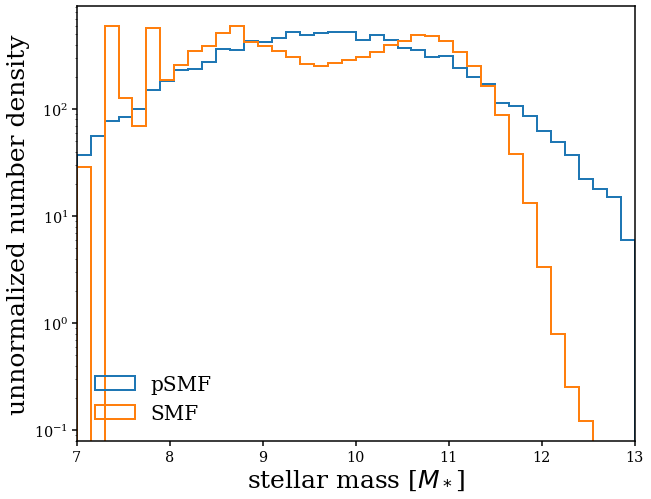

In [72]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
_ = sub.hist(np.array(post_prime.detach().cpu()), range=(7., 13.), bins=40, 
             histtype='step', linewidth=2, label='pSMF')

_ = sub.hist(np.median(logM_posteriors, axis=1), 
         weights=w_import*10000./np.sum(w_import), 
         range=(7., 13.), bins=40, histtype='step', linewidth=2, label='SMF')

sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'stellar mass [$M_*$]', fontsize=25)
sub.set_xlim(7., 13.)
sub.set_ylabel(r'unnormalized number density', fontsize=25)
sub.set_yscale('log')


# calculate normalization

In [73]:
footprint = 168.8264 / (4 * np.pi * (180/np.pi)**2) # sq. deg

In [74]:
nbar_total = np.sum(bgs['WEIGHT'] / vmaxes / footprint) # (Mpc/h)^(-3)
print(nbar_total)

0.05167709231549672


(1e-07, 0.031696119155579565)

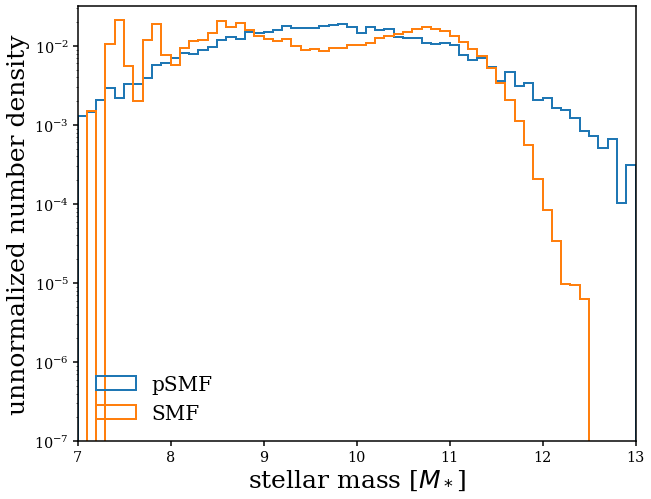

In [75]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
_ = sub.hist(np.array(post_prime.detach().cpu()),
             weights=np.repeat(nbar_total/10000./0.1, 10000), 
             range=(7., 13.), bins=60, histtype='step', linewidth=2, label='pSMF')

_ = sub.hist(np.median(logM_posteriors, axis=1), 
         weights=w_import*nbar_total/np.sum(w_import)/0.1, 
         range=(7., 13.), bins=60, histtype='step', linewidth=2, label='SMF')

sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'stellar mass [$M_*$]', fontsize=25)
sub.set_xlim(7., 13.)
sub.set_ylabel(r'unnormalized number density', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-7, None)

(1e-07, 0.031696119155579565)

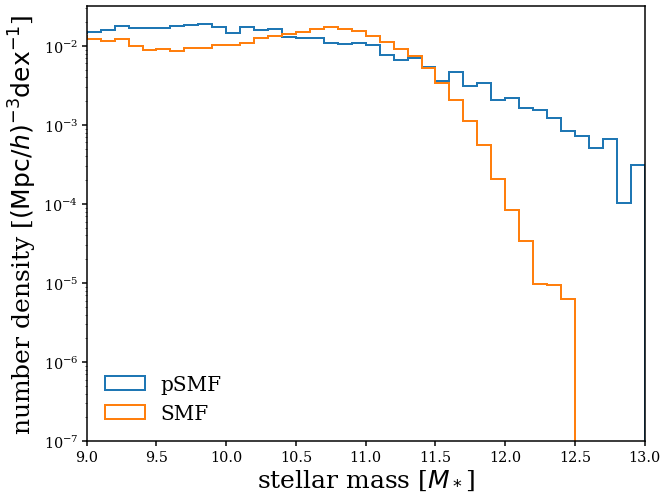

In [76]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
_ = sub.hist(np.array(post_prime.detach().cpu()),
             weights=np.repeat(nbar_total/10000./0.1, 10000), 
             range=(7., 13.), bins=60, histtype='step', linewidth=2, label='pSMF')

_ = sub.hist(np.median(logM_posteriors, axis=1), 
         weights=w_import*nbar_total/np.sum(w_import)/0.1, 
         range=(7., 13.), bins=60, histtype='step', linewidth=2, label='SMF')

sub.legend(loc='lower left', fontsize=20)
sub.set_xlabel(r'stellar mass [$M_*$]', fontsize=25)
sub.set_xlim(9., 13.)
sub.set_ylabel(r'number density [$({\rm Mpc}/h)^{-3} {\rm dex}^{-1}$]', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-7, None)